In [1]:
import numpy as np
import matplotlib.pyplot as plt


class Interpolation:

    def __init__(self, x, y):
        self.__set___x(x)
        self.__set___y(y)
        self.__set_bins()
        self.__set_coefficients()

    def __set___x(self, x):
        if len(x) % 2:
            self.__x = x
        else:
            self.__x = x[:-1]

    def __set___y(self, y):
        if len(y) % 2:
            self.__y = y
        else:
            self.__y = y[:-1]

    def get___y(self):
        return self.__y

    def __set_bins(self):
        self.bins = self.__x[:-1:2]

    def __set_coefficients(self):

        def interpolate(x, y):
            a = ((y[0] - y[1])*(x[1] - x[2]) - (y[1] - y[2])*(x[0] - x[1]))/((x[0]**2 - x[1]**2)*(x[1] - x[2]) - (x[1]**2 - x[2]**2)*(x[0] - x[1]))
            b = ((y[1] - y[2]) - a*(x[1]**2 - x[2]**2))/(x[1] - x[2])
            c = y[0] - a*x[0]**2 - b*x[0]

            return a, b, c          

        coefficients = []

        for i in range(len(self.__x)-1)[::2]:
            coefficients.append(interpolate([self.__x[i], self.__x[i+1], self.__x[i+2]], [self.__y[i], self.__y[i+1], self.__y[i+2],]))

        self.coefficients = coefficients

    def get_bin(self, x):
        if x < self.bins[0]:
            bin = -1
        elif x > self.bins[-1]:
            bin = len(self.bins)
        else:
            i = 0
            while x > self.bins[i+1]:
                i +=1
            bin = i
        
        return bin

    def get_coefficients(self, x):
        i = self.get_bin(x)
        
        if i == -1:
            a = 0
            b = 0
            c = self.coefficients[0][2]
        elif i == len(self.bins):
            a = 0
            b = 0
            c = self.coefficients[-1][2]           
        else:
            a = self.coefficients[i][0]
            b = self.coefficients[i][1]
            c = self.coefficients[i][2]

        # if x < self.bins[0]:
        #     a = 0
        #     b = 0
        #     c = self.coefficients[0][2]
        # elif x > self.bins[-1]:
        #     a = 0
        #     b = 0
        #     c = self.coefficients[-1][2]
        # else:
        #     i = 0
        #     while x > self.bins[i+1]:
        #         i +=1
        #     a = self.coefficients[i][0]
        #     b = self.coefficients[i][1]
        #     c = self.coefficients[i][2]
        return a, b, c

    def evaluate(self, x):
        a, b, c = self.get_coefficients(x)
        return a*x**2 + b*x + c


class Integral:

    def __init__(self, func, num=10000):
        self.__func = func
        self.__num_bins = num
        self.__set___mid_point()
        self.__set___end_points()
        self.__set___func_interpolation()
  
    def __set___mid_point(self):
        step = 1e-1
        x_0 = 0

        if self.__func(x_0 + step) > self.__func(x_0):

            while step > 1e-6:

                p_0 = self.__func(x_0)
                p_1 = self.__func(x_0 + step)

                while p_1 < p_0:

                    step = step/2
                    p_1 = self.__func(x_0 + step)

                x_0 = x_0 + step
        
        if self.__func(x_0 + step) < self.__func(x_0):

            while step > 1e-6:

                p_0 = self.__func(x_0)
                p_1 = self.__func(x_0 - step)

                while p_1 < p_0:

                    step = step/2
                    p_1 = self.__func(x_0 - step)

                x_0 = x_0 + step

        self.__mid_point = x_0
        
    def __set___end_points(self):
        x_inf = self.__mid_point
        x_sup = x_inf
        step_inf = 1e-1
        step_sup = 1e-1

        step_bound = 1/self.__num_bins**2
        p_bound = 1/self.__num_bins**2

        while step_inf > step_bound:

            p_inf_0 = self.__func(x_inf)
            p_inf_1 = self.__func(x_inf - step_inf)

            while p_inf_1 < p_bound:

                step_inf = step_inf/2
                p_inf_1 = self.__func(x_inf - step_inf)

            x_inf = x_inf - step_inf

        while step_sup > step_bound:

            p_sup_0 = self.__func(x_sup)
            p_sup_1 = self.__func(x_sup + step_sup)

            while p_sup_1 < p_bound:

                step_sup = step_sup/2
                p_sup_1 = self.__func(x_sup + step_sup)

            x_sup = x_sup + step_sup

        self.__end_points = (x_inf, x_sup)

    def __set___func_interpolation(self):
        lower_bound, higher_bound = self.__end_points

        self.__x = np.linspace(lower_bound, higher_bound, 2*self.__num_bins + 1)
        self.__f = [self.__func(x_i) for x_i in self.__x]

        self.__func_interpolation = Interpolation(self.__x, self.__f)

    def get_end_points(self):
        return self.__end_points

    def integrate(self, x_1, x_2):
        x = self.__func_interpolation.bins

        i = self.__func_interpolation.get_bin(x_1)
        j = self.__func_interpolation.get_bin(x_2)

        # i = 0
        # while x_1 > x[i+1]:
        #     i += 1\

        if i == j:
            a, b, c = self.__func_interpolation.get_coefficients(x_1)
            integral = a/3*(x_2**3 - x_1**3) + b/2*(x_2**2 - x_1**2) + c*(x_2 - x_1)

        else:
            if i == -1:
                lower_integral = 0
            else:
                a, b, c = self.__func_interpolation.get_coefficients(x_1)
                lower_integral = a/3*(x[i+1]**3 - x_1**3) + b/2*(x[i+1]**2 - x_1**2) + c*(x[i+1] - x_1)

            middle_integral = 0

            while i < j-1:
                a, b, c = self.__func_interpolation.coefficients[i]
                middle_integral += a/3*(x[i+1]**3 - x[i]**3) + b/2*(x[i+1]**2 - x[i]**2) + c*(x[i+1] - x[i])
                i += 1
            
            if j == len(x):
                higher_integral = 0
            else:
                a, b, c = self.__func_interpolation.get_coefficients(x_2)
                higher_integral = a/3*(x_2**3 - x[j]**3) + b/2*(x_2**2 - x[j]**2) + c*(x_2 - x[j])
            
            integral = lower_integral + middle_integral + higher_integral

        return integral
        

class Sampler:

    def __init__(self, pdf, num=10000):
        # self.__distribution = pdf
        self.__num = num
        self.integral = Integral(pdf, num)
        self.__set___interpolation()

    def __set___interpolation(self):
        lower_bound, higher_bound = self.integral.get_end_points()

        self.__x = np.linspace(lower_bound, higher_bound, 2*self.__num+1)
        cumulative = [0]

        for i in range(1, len(self.__x)):
            partial = self.integral.integrate(self.__x[i-1], self.__x[i])
            cumulative.append(cumulative[-1]+partial)

        self.__cumulative = cumulative

        # print(cumulative)
        self.interpolation = Interpolation(self.__cumulative, self.__x)

    def get___cumulative(self):
        return self.__cumulative

    def get___x(self):
        return self.__x

    def sample(self, size):
        draw = np.random.uniform(0, 1, size)
        # print(draw)
        return [self.interpolation.evaluate(x) for x in draw]



In [2]:
def gaussian(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [3]:
gaussian_integral = Integral(gaussian, 5)

In [4]:
gaussian_sampler = Sampler(gaussian, 1000)

In [5]:
# samples = gaussian_sampler.sample(1000)
samples = gaussian_sampler.sample(1000)

(-4.0, 4.0)

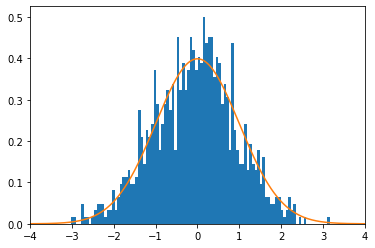

In [6]:
plt.hist(samples, bins=100, density=True)
x = gaussian_sampler.interpolation.get___y()
y = []
for x_i in x:
    y.append(gaussian(x_i))
plt.plot(x, y)
plt.xlim(-4, 4)

In [7]:
def poisson(x):
    return 2**x*np.exp(-2)/np.math.gamma(x+1)

In [8]:
poisson_sampler = Sampler(poisson, 1000)

In [9]:
samples = poisson_sampler.sample(100000)

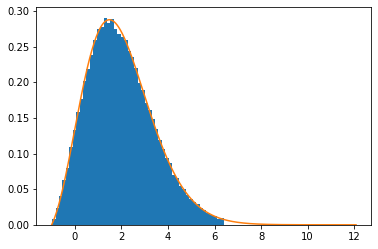

In [10]:
plt.hist(samples, bins=50, density=True)
x = poisson_sampler.interpolation.get___y()
y = []
for x_i in x:
    y.append(poisson(x_i))
plt.plot(x, y)
# plt.xlim(-4, 4)